## COMP0162 2023/24 Advanced Machine Learning in Finance Coursework 

In [36]:
from collections import deque
import random
import time
import calendar
import datetime
from datetime import date, timedelta

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pandas_datareader import data as pdr
import yfinance as yf
import ccxt
import mplfinance as mpf

import tensorflow.compat.v1 as tf

In [37]:
tf.compat.v1.disable_eager_execution()

# Initialize the exchange
exchange = ccxt.kucoin()

# Define the start and end dates for training and testing periods
start_date_training = '2024-01-01'
end_date_training = '2024-01-15'
start_date_test = '2024-01-15'
end_date_test = '2024-01-20'

# Function to fetch hourly prices for a given period
def fetch_hourly_prices_for_period(symbol, start_date, end_date):
    since = exchange.parse8601(f'{start_date}T00:00:00Z')
    end_timestamp = exchange.parse8601(f'{end_date}T00:00:00Z')
    all_ohlcv = []
    while since < end_timestamp:
        ohlcv = exchange.fetch_ohlcv(symbol, '1h', since=since, limit=1000)  # Fetch a batch of 1000 bars
        if len(ohlcv) == 0:  # No more data
            break
        since = ohlcv[-1][0] + 1  # Prepare the since timestamp for the next query
        all_ohlcv.extend(ohlcv)
    df = pd.DataFrame(all_ohlcv, columns=['Time', 'Open', 'High', 'Low', 'Close', 'Volume'])
    df['Time'] = pd.to_datetime(df['Time'], unit='ms')
    df.set_index('Time', inplace=True)
    return df

# Fetch training and testing data for BTC/USDT
btc_training = fetch_hourly_prices_for_period('BTC/USDT', start_date_training, end_date_training)
btc_test = fetch_hourly_prices_for_period('BTC/USDT', start_date_test, end_date_test)

# Fetch training and testing data for MEME/USDT
meme_training = fetch_hourly_prices_for_period('MEME/USDT', start_date_training, end_date_training)
meme_test = fetch_hourly_prices_for_period('MEME/USDT', start_date_test, end_date_test)

# Fetch training and testing data for DOGE/USDT
doge_training = fetch_hourly_prices_for_period('DOGE/USDT', start_date_training, end_date_training)
doge_test = fetch_hourly_prices_for_period('DOGE/USDT', start_date_test, end_date_test)

# Fetch training and testing data for PEPE/USDT
pepe_training = fetch_hourly_prices_for_period('PEPE/USDT', start_date_training, end_date_training)
pepe_test = fetch_hourly_prices_for_period('PEPE/USDT', start_date_test, end_date_test)

In [38]:
btc_training.head(3) # Visualize the training dataset.

,Open,High,Low,Close,Volume
Time,,,,,
2024-01-01 00:00:00,42278.8,42551.8,42261.5,42474.1,79.691071
2024-01-01 01:00:00,42474.0,42772.8,42427.8,42612.1,97.272520
2024-01-01 02:00:00,42612.0,42638.9,42502.9,42582.9,39.095579


In [39]:
btc_test.head(3) # Visualize the test dataset.

,Open,High,Low,Close,Volume
Time,,,,,
2024-01-15 00:00:00,41727.2,42351.7,41715.7,42253.3,145.506243
2024-01-15 01:00:00,42273.4,42390.2,42178.4,42277.4,93.861603
2024-01-15 02:00:00,42277.4,42405.9,42195.5,42395.7,66.801264


In [40]:
meme_training.head()

,Open,High,Low,Close,Volume
Time,,,,,
2024-01-01 00:00:00,0.027297,0.027459,0.027118,0.027346,1.464975e+06
2024-01-01 01:00:00,0.027352,0.027764,0.027352,0.027541,8.113872e+05
2024-01-01 02:00:00,0.027541,0.027541,0.027089,0.027155,1.197465e+06
2024-01-01 03:00:00,0.027162,0.027170,0.026525,0.026714,1.928971e+06
2024-01-01 04:00:00,0.026726,0.026861,0.025202,0.026018,8.182902e+06


In [41]:
meme_test.head()

,Open,High,Low,Close,Volume
Time,,,,,
2024-01-15 00:00:00,0.027400,0.028665,0.027364,0.028656,3.348774e+06
2024-01-15 01:00:00,0.028677,0.029163,0.028498,0.028898,2.521742e+06
2024-01-15 02:00:00,0.028880,0.029358,0.028615,0.029140,3.588763e+06
2024-01-15 03:00:00,0.029177,0.029469,0.029020,0.029167,1.389574e+06
2024-01-15 04:00:00,0.029132,0.029132,0.028337,0.028486,3.371056e+06


In [42]:
doge_training.head()

,Open,High,Low,Close,Volume
Time,,,,,
2024-01-01 00:00:00,0.08952,0.08999,0.08948,0.08986,4.579677e+06
2024-01-01 01:00:00,0.08983,0.09023,0.08956,0.09015,1.009046e+06
2024-01-01 02:00:00,0.09014,0.09015,0.08974,0.08981,5.624954e+05
2024-01-01 03:00:00,0.08983,0.08991,0.08901,0.08925,9.162950e+05
2024-01-01 04:00:00,0.08920,0.08939,0.08846,0.08916,1.780013e+06


In [43]:
doge_test.head()

,Open,High,Low,Close,Volume
Time,,,,,
2024-01-15 00:00:00,0.08003,0.08086,0.08000,0.08079,2.376536e+06
2024-01-15 01:00:00,0.08081,0.08095,0.08045,0.08082,2.132029e+06
2024-01-15 02:00:00,0.08085,0.08128,0.08071,0.08128,8.178400e+05
2024-01-15 03:00:00,0.08128,0.08145,0.08103,0.08115,1.294747e+06
2024-01-15 04:00:00,0.08120,0.08154,0.08119,0.08151,5.948485e+05


In [44]:
pepe_training.head()

,Open,High,Low,Close,Volume
Time,,,,,
2024-01-01 00:00:00,0.000001,0.000001,0.000001,0.000001,1.250007e+11
2024-01-01 01:00:00,0.000001,0.000001,0.000001,0.000001,1.921722e+11
2024-01-01 02:00:00,0.000001,0.000001,0.000001,0.000001,1.062966e+11
2024-01-01 03:00:00,0.000001,0.000001,0.000001,0.000001,1.495366e+11
2024-01-01 04:00:00,0.000001,0.000001,0.000001,0.000001,1.177309e+11


In [45]:
pepe_test.head()

,Open,High,Low,Close,Volume
Time,,,,,
2024-01-15 00:00:00,0.000001,0.000001,0.000001,0.000001,1.046661e+11
2024-01-15 01:00:00,0.000001,0.000001,0.000001,0.000001,1.529504e+11
2024-01-15 02:00:00,0.000001,0.000001,0.000001,0.000001,7.473491e+10
2024-01-15 03:00:00,0.000001,0.000001,0.000001,0.000001,7.830682e+10
2024-01-15 04:00:00,0.000001,0.000001,0.000001,0.000001,2.352692e+10


### Reinforcement Learning

In [46]:
df = btc_training.copy()
name = 'SimplisticDeepQTrader'

In [47]:
class DQN_Trader:
    
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2 # Round the result down to the nearest whole number.
        self.trend = trend
        self.skip = skip
        self.action_size = 3 # Action 0 -> Hold; Action 1 -> Buy; Action 2 -> Sell.
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []
        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999
        
        # Reset the TensorFlow default graph to clear any existing tensors and operations.
        tf.reset_default_graph()

        # Create an interactive TensorFlow session.
        self.sess = tf.InteractiveSession()

        # Create a TensorFlow placeholder for the input state of the network.
        # The first dimension of the placeholder is "None", which means it can take any batch size.
        # The second dimension is the size of the state vector.
        self.X = tf.placeholder(tf.float32, [None, self.state_size])

        # Create a TensorFlow placeholder for the output action of the network.
        # The first dimension of the placeholder is "None", which means it can take any batch size.
        # The second dimension is the size of the action vector.
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])

        # Create a fully connected layer with 256 units and ReLU activation function.
        # The input to this layer is the state vector.
        # The output is the hidden layer output.
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)

        # Create a fully connected layer with size equal to the action vector size.
        # The input to this layer is the hidden layer output.
        # The output is the output of the network.
        self.logits = tf.layers.dense(feed, self.action_size)

        # Compute the mean squared error between the output of the network and the target action.
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))

        # Create a gradient descent optimizer with a learning rate of 1e-5.
        # Minimize the cost using the optimizer.
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(self.cost)

        # Initialize all variables in the TensorFlow graph.
        self.sess.run(tf.global_variables_initializer())

        
    def act(self, state):
        # If a random number is less than the exploration rate, select a random action.
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)

        # Otherwise, given the current state, use the neural network to select the action with the highest probability.
        # The action with the highest probability is the one with the highest output value from the logits layer.
        return np.argmax(self.sess.run(self.logits, feed_dict = {self.X: state})[0])

    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]

        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        
        return np.array([res])

    
    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)

        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])

        replay_size = len(mini_batch)

        # Create empty arrays to hold the state and target data
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))

        # Extract the states and next states from the mini batch
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])

        # Obtain Q values for the current and next states
        Q = self.sess.run(self.logits, feed_dict={self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict={self.X: new_states})

        # Loop through the mini batch and update the target Q values
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward

            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])

            X[i] = state
            Y[i] = target

        # Train the neural network on the state and target data
        cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict={self.X: X, self.Y: Y})

        # Decay the exploration rate
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        # Return the cost of the neural network during training
        return cost
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            # Initialize variables for the current episode
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money

            # Iterate over the time steps in the trend data
            for t in range(0, len(self.trend) - 1, self.skip):
                # Take an action based on the current state
                action = self.act(state)
                # Get the next state
                next_state = self.get_state(t + 1)

                # If the action is "buy" and there is enough money to buy, add to inventory
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]

                # If the action is "sell" and there is inventory to sell, sell at current price
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]

                # Calculate the investment return and add the current step to the replay buffer
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, next_state, starting_money < initial_money))

                # Update the state for the next step and replay the buffer
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)

            # Print the progress at the checkpoint interval
            if (i+1) % checkpoint == 0:
                print(f'Epoch: {i+1} | Total rewards: {total_profit} | Cost: {cost} | Total money {starting_money}')
                
                
    def test(self, initial_money, trend):
        self.trend = trend
        starting_money = initial_money

        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        gains_at_each_sale = []  # List to store gains at each sale

        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)

            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print(f'Hour {t}: buy 1 unit at price {self.trend[t]}, total balance {initial_money}')

            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                profit = self.trend[t] - bought_price  # Calculate profit
                gains_at_each_sale.append(profit)  # Store the profit
                initial_money += self.trend[t]
                states_sell.append(t)
                print(f'Hour {t}: sell 1 unit at price {self.trend[t]}, profit {profit}, total balance {initial_money}')

            state = next_state

        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest, gains_at_each_sale

In [48]:
close_training = btc_training.Close.values.tolist() # Get closing prices.
close_test = btc_test.Close.values.tolist() # Get closing prices.

initial_money = 100000 # Initial amount of money.
window_size = 5 # Lookback window
skip = 1 # Overlap regulator.
batch_size = 64
iterations = 50
checkpoint = 5

# Initialize and train a Trader agent for BTC/USDT
btc_agent = DQN_Trader(state_size=window_size, window_size=window_size, trend=btc_training.Close.values.tolist(), skip=skip, batch_size=batch_size)
btc_agent.train(iterations=iterations, checkpoint=checkpoint, initial_money=initial_money)

# # Initialize and train a Trader agent for MEME/USDT
# meme_agent = DQN_Trader(state_size=window_size, window_size=window_size, trend=meme_training.Close.values.tolist(), skip=skip, batch_size=batch_size)
# meme_agent.train(iterations=iterations, checkpoint=checkpoint, initial_money=initial_money)

# # Initialize and train a Trader agent for DOGE/USDT
# doge_agent = DQN_Trader(state_size=window_size, window_size=window_size, trend=doge_training.Close.values.tolist(), skip=skip, batch_size=batch_size)
# doge_agent.train(iterations=iterations, checkpoint=checkpoint, initial_money=initial_money)

# # Initialize and train a Trader agent for PEPE/USDT
# pepe_agent = DQN_Trader(state_size=window_size, window_size=window_size, trend=pepe_training.Close.values.tolist(), skip=skip, batch_size=batch_size)
# pepe_agent.train(iterations=iterations, checkpoint=checkpoint, initial_money=initial_money)

c:\Users\lyakh\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\client\session.py:1770: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
C:\Users\lyakh\AppData\Local\Temp\ipykernel_30420\773440870.py:38: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
C:\Users\lyakh\AppData\Local\Temp\ipykernel_30420\773440870.py:43: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.layers.dense(feed, self.action_size)


Epoch: 5 | Total rewards: 9554.099999999999 | Cost: 1.3996788263320923 | Total money 61674.100000000006
Epoch: 10 | Total rewards: 5442.5 | Cost: 0.43721237778663635 | Total money 11184.39999999998
Epoch: 15 | Total rewards: 4220.099999999991 | Cost: 0.15061606466770172 | Total money 9087.099999999991
Epoch: 20 | Total rewards: 6992.799999999996 | Cost: 0.14636602997779846 | Total money 58854.899999999965
Epoch: 25 | Total rewards: 3720.4999999999563 | Cost: 0.12243057042360306 | Total money 55430.19999999995
Epoch: 30 | Total rewards: -7431.900000000016 | Cost: 0.08138370513916016 | Total money 92568.09999999995
Epoch: 35 | Total rewards: -5066.29999999993 | Cost: 0.08342603594064713 | Total money 94933.70000000004
Epoch: 40 | Total rewards: -11231.299999999988 | Cost: 0.06298903375864029 | Total money 88768.70000000001
Epoch: 45 | Total rewards: -10192.599999999948 | Cost: 0.05836835876107216 | Total money 89807.40000000002
Epoch: 50 | Total rewards: -12187.399999999972 | Cost: 0.051

In [49]:
# Test the agents with the testing data
btc_states_buy, btc_states_sell, btc_total_gains, btc_invest, btc_gains_at_each_sale = btc_agent.test(initial_money=initial_money, trend=btc_test.Close.values.tolist())
# meme_states_buy, meme_states_sell, meme_total_gains, meme_invest, meme_gains_at_each_sale = meme_agent.test(initial_money=initial_money, trend=meme_test.Close.values.tolist())
# doge_states_buy, doge_states_sell, doge_total_gains, doge_invest, doge_gains_at_each_sale = doge_agent.test(initial_money=initial_money, trend=doge_test.Close.values.tolist())
# pepe_states_buy, pepe_states_sell, pepe_total_gains, pepe_invest, pepe_gains_at_each_sale = pepe_agent.test(initial_money=initial_money, trend=pepe_test.Close.values.tolist())

# Calculate the cumulative gains for each pair
btc_cumulative_gains = np.cumsum(btc_gains_at_each_sale)
# meme_cumulative_gains = np.cumsum(meme_gains_at_each_sale)
# doge_cumulative_gains = np.cumsum(doge_gains_at_each_sale)
# pepe_cumulative_gains = np.cumsum(pepe_gains_at_each_sale)



Hour 4: buy 1 unit at price 42596.6, total balance 57403.4
Hour 5: sell 1 unit at price 42734.3, profit 137.70000000000437, total balance 100137.70000000001
Hour 6: buy 1 unit at price 42648.2, total balance 57489.500000000015
Hour 7: sell 1 unit at price 42709.8, profit 61.60000000000582, total balance 100199.30000000002
Hour 10: buy 1 unit at price 42562.1, total balance 57637.20000000002
Hour 11: sell 1 unit at price 42696.9, profit 134.8000000000029, total balance 100334.10000000002
Hour 19: buy 1 unit at price 42990.5, total balance 57343.60000000002
Hour 20: sell 1 unit at price 42958.8, profit -31.69999999999709, total balance 100302.40000000002
Hour 23: buy 1 unit at price 42523.6, total balance 57778.800000000025
Hour 24: buy 1 unit at price 42599.6, total balance 15179.200000000026
Hour 25: sell 1 unit at price 42584.8, profit 61.200000000004366, total balance 57764.00000000003
Hour 26: sell 1 unit at price 42706.2, profit 106.59999999999854, total balance 100470.20000000003


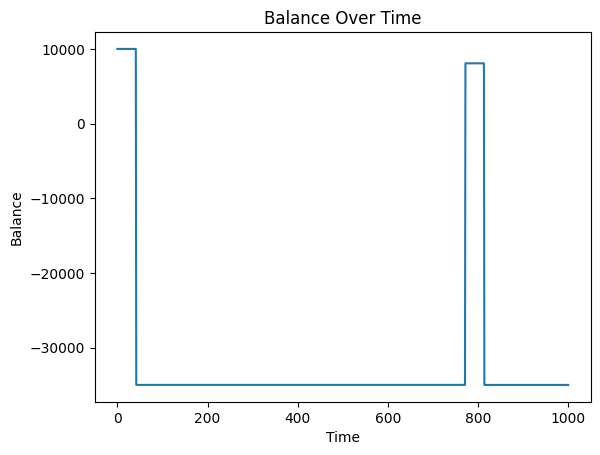

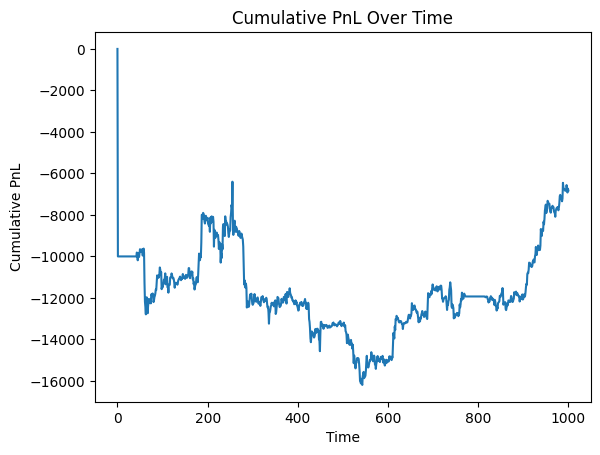

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

class TradingAgent:
    def __init__(self, actions, state_size, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, gamma=0.95, alpha=0.05):
        self.state_size = state_size
        self.action_size = len(actions)
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.gamma = gamma
        self.alpha = alpha
        self.q_table = np.zeros((state_size, self.action_size))
        self.actions = actions

    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.actions)
        return np.argmax(self.q_table[state])

    def update_q_table(self, state, action_index, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.gamma * self.q_table[next_state, best_next_action]
        td_delta = td_target - self.q_table[state, action_index]
        self.q_table[state, action_index] += self.alpha * td_delta

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

class TradingEnvironment:
    def __init__(self, prices):
        self.prices = prices['Close'].values
        self.n = len(self.prices)
        self.current_index = 0
        self.cash = 10000
        self.holding = False
        self.initial_cash = 10000
        self.balance_history = []  # To track balance over time
        self.pnl_history = []  # To track cumulative PnL

    def reset(self):
        self.current_index = 0
        self.cash = self.initial_cash
        self.holding = False
        self.balance_history = [self.initial_cash]
        self.pnl_history = [0]
        return self._get_state()

    def _get_state(self):
        return 1 if self.holding else 0

    def step(self, action):
        reward = 0
        done = False

        if action == 1 and not self.holding:  # Buy
            self.holding = True
            self.cash -= self.prices[self.current_index]

        elif action == 2 and self.holding:  # Sell
            self.holding = False
            self.cash += self.prices[self.current_index]
            reward = self.cash - self.initial_cash

        # Update balance and PnL history
        self.balance_history.append(self.cash)
        self.pnl_history.append(self.cash - self.initial_cash + (self.prices[self.current_index] if self.holding else 0) - self.initial_cash)

        self.current_index += 1
        if self.current_index >= self.n:
            done = True

        next_state = self._get_state()
        return next_state, reward, done

def train_agent(episodes=100, btc_prices=btc_training):
    env = TradingEnvironment(btc_prices)
    agent = TradingAgent(actions=[0, 1, 2], state_size=2)

    for e in range(episodes):
        state = env.reset()

        while True:
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            agent.update_q_table(state, action, reward, next_state)
            state = next_state
            if done:
                break

    return env.balance_history, env.pnl_history

# Get balance and cumulative PnL data
balance_history, pnl_history = train_agent()

# Plotting balance over time
plt.figure()
plt.plot(balance_history)
plt.title('Balance Over Time')
plt.xlabel('Time')
plt.ylabel('Balance')
plt.show()

# Plotting cumulative PnL
plt.figure()
plt.plot(pnl_history)
plt.title('Cumulative PnL Over Time')
plt.xlabel('Time')
plt.ylabel('Cumulative PnL')
plt.show()



Step 0: Balance 100000, Cumulative PnL 0.0
Step 5: Balance 99746.7, Cumulative PnL -253.3000000000029
Step 10: Balance 57258.2, Cumulative PnL -51.39999999999418
Step 15: Balance 57088.9, Cumulative PnL -132.0
Step 20: Balance 57088.9, Cumulative PnL 775.3000000000029
Step 25: Balance 57088.9, Cumulative PnL 1943.8999999999942
Step 30: Balance 102265.70000000001, Cumulative PnL 2265.7000000000116
Step 35: Balance 102235.6, Cumulative PnL 2235.600000000006
Step 40: Balance 102158.5, Cumulative PnL 2158.5
Step 45: Balance 102158.5, Cumulative PnL 2158.5
Step 50: Balance 56980.59999999999, Cumulative PnL 2259.6999999999825
Step 55: Balance 101850.4, Cumulative PnL 1850.3999999999942
Step 60: Balance 100199.4, Cumulative PnL 199.39999999999418
Step 65: Balance 57204.7, Cumulative PnL 110.39999999999418
Step 70: Balance 56514.40000000001, Cumulative PnL -735.8999999999942
Step 75: Balance 56081.0, Cumulative PnL -812.1999999999971
Step 80: Balance 98848.2, Cumulative PnL -1151.800000000003


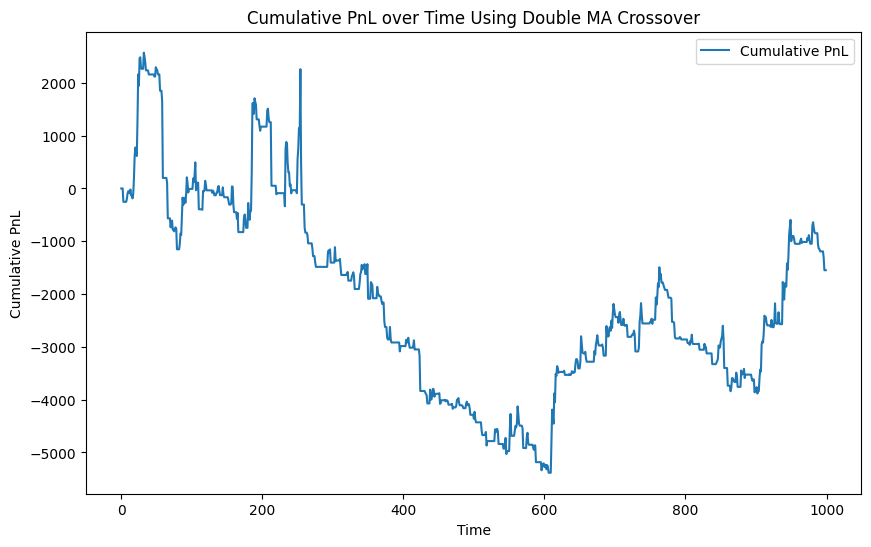

In [51]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming btc_training is a DataFrame containing the fetched BTC hourly prices for training

# Define the short-term and long-term window sizes
short_window = window_size // 2  # Half of the DQN window size
long_window = window_size        # Same as the DQN window size

# Calculate the moving averages
btc_training['short_mavg'] = btc_training['Close'].rolling(window=short_window, min_periods=1).mean()
btc_training['long_mavg'] = btc_training['Close'].rolling(window=long_window, min_periods=1).mean()

# Initialize the signal column
btc_training['signal'] = np.where(btc_training['short_mavg'] > btc_training['long_mavg'], 1, 0)

# Generate trading orders
btc_training['positions'] = btc_training['signal'].diff()

# Initialize portfolio with the same budget as DQN_Trader: 100,000 units
initial_capital = 100000
capital = initial_capital
btc_held = 0
trade_checkpoint = 5  # Print details every 5 steps
cum_pnl = []  # List to track cumulative PnL

for i, (price, position) in enumerate(zip(btc_training['Close'], btc_training['positions'])):
    if position == 1:  # Buy
        btc_held += 1
        capital -= price
    elif position == -1 and btc_held > 0:  # Sell
        btc_held -= 1
        capital += price

    # Calculate and store cumulative PnL
    current_pnl = capital + btc_held * price - initial_capital
    cum_pnl.append(current_pnl)

    if i % trade_checkpoint == 0:
        print(f"Step {i}: Balance {capital}, Cumulative PnL {current_pnl}")

# Final Portfolio Value and Total Profit
final_value = capital + btc_held * btc_training.iloc[-1]['Close']
total_profit = final_value - initial_capital
print(f"Final portfolio value: {final_value}")
print(f"Total profit: {total_profit}")

# Plot Cumulative PnL over time
plt.figure(figsize=(10,6))
plt.plot(cum_pnl, label='Cumulative PnL')
plt.title('Cumulative PnL over Time Using Double MA Crossover')
plt.xlabel('Time')
plt.ylabel('Cumulative PnL')
plt.legend()
plt.show()
